In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, accuracy_score

%matplotlib inline

//anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
//anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
//anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
//anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
baseline = pd.read_csv("PovertyTrackerData/Annual/Poverty-Tracker-Study-Baseline-raw.csv")
threemonth = pd.read_csv("PovertyTrackerData/Interim/Poverty Tracker Study - 3M - raw.csv")
sixmonth = pd.read_csv("PovertyTrackerData/Interim/Poverty Tracker Study - 6M - raw.csv")
ninemonth = pd.read_csv("PovertyTrackerData/Interim/Poverty Tracker Study - 9M - raw.csv")
oneyear = pd.read_csv("PovertyTrackerData/Annual/Poverty-Tracker-Study-12M-raw.csv")
twoyear = pd.read_csv("PovertyTrackerData/Annual/Poverty-Tracker-Study-24M-raw.csv")

### First Goal: Predict OPM binary classification at one year using only baseline data, then only interim data at 3,6,9 months, then both.
#### Methods: Logistic Regression, Naive Bayes, Random Forests, Nearest Neighbors, Neural Networks

In [145]:
# Prepping the data
# from sklearn.model_selection import train_test_split

# Combine the baseline and interim datasets
fulldata = pd.concat([baseline, threemonth, sixmonth, ninemonth], axis=1)
fulldata = fulldata.loc[:,~fulldata.columns.duplicated()]
fulldata = fulldata.drop(['SUBJECT_ID','INC_12', 'SINC_12','GENDER_12','OPM_12'], axis=1)

fulldata = fulldata.replace(['97','98','99', 97, 98, 99,1900.01,1899.12,1900.10],np.NaN)
fulldata.to_csv('PovertyTrackerData/CleanedDataset.csv')
outcome = oneyear.OPM_12

# INC_12, SINC_12 are the imputed values at the one-year baseline. They mostly replace NaNs.
# GENDER from baseline has no NaNs, while GENDER_12 from threemonth has 900 NaNs.

mainfeatures = ['AGE','GENDER','OPM_BASE', 'OPMTHRESH_BASE', 'OPMRES_BASE',
       'SPM_BASE', 'SPMTHRESH_BASE', 'SPMRES_BASE', 'FOODFREE_BASE',
       'FOODAMOUNT_BASE', 'FOODWORRY_BASE', 'FOODRUNOUT_BASE',
       'HOUSE_PAID_IN_FULL_BASE', 'HOUSE_OTHERS_BASE', 'HOUSE_SHELTER_BASE',
       'UTIL_PAID_BASE', 'UTIL_CUTOFF_BASE', 'MONEY_RUNOUT_BASE',
       'MEDIC_HELP_BASE', 'HEALTHCOND_BASE', 'HEALTHDISAB_BASE',
       'HEALTHDPRSS_BASE', 'HEALTHANXIOUS_BASE',
      'FIN_BENEF_DECR_3', 'FIN_MAJOR_EXPENSE_3', 'FIN_INCOM_DECR_3',
       'REL_END_3', 'MEDICAL_SHOCK_3', 'CRIME_VICTIM_3',
       'CRIME_LOSS_PROPERTY_3', 'POLICE_STOP_3', 'OTHER_MAJOR_CHANGE_3',
      'FIN_BENEF_DECR_6', 'FIN_MAJOR_EXPENSE_6',
       'FIN_INCOM_DECR_6', 'REL_END_6', 'MEDICAL_SHOCK_6', 'CRIME_VICTIM_6',
       'CRIME_LOSS_PROPERTY_6', 'POLICE_STOP_6', 'OTHER_MAJOR_CHANGE_6',
      'FIN_BENEF_DECR_9', 'FIN_MAJOR_EXPENSE_9',
       'FIN_INCOM_DECR_9', 'REL_END_9', 'MEDICAL_SHOCK_9', 'CRIME_VICTIM_9',
       'CRIME_LOSS_PROPERTY_9', 'POLICE_STOP_9', 'OTHER_MAJOR_CHANGE_9']

In [7]:
# Summary Statistics

print(sum(outcome == 2)) # number of people above the OPM threshold
print(sum(outcome == 1)) # number of people below the OPM threshold
#55.7% of this sample is below the OPM threshold. That's a lot!
print(fulldata['MONEY_RUNOUT_3'].value_counts())
print(fulldata['OPM_BASE'].value_counts())
print(fulldata['FIN_BENEF_DECR_6'].value_counts()) # 2 is no, 1 is yes
print(fulldata['HEALTHCOND_6'].value_counts()) # 1 is excellent, 5 is poor
print(fulldata['FIN_INCOM_DECR_3'].value_counts()) # 2  is no, 1 is yes
print(fulldata['MEDIC_HELP_3'].value_counts()) # 2 is no, 1 is yes
print(fulldata['INC_IMP_BASE'].value_counts()) # 2  is no, 1 is yes



986
1242
3.0    599
2.0    446
1.0    282
Name: MONEY_RUNOUT_3, dtype: int64
2    1631
1     597
Name: OPM_BASE, dtype: int64
2.0    1241
1.0      85
Name: FIN_BENEF_DECR_6, dtype: int64
3.0    400
2.0    380
4.0    243
1.0    193
5.0     71
Name: HEALTHCOND_6, dtype: int64
2.0    1110
1.0     202
Name: FIN_INCOM_DECR_3, dtype: int64
2.0    1131
1.0     201
Name: MEDIC_HELP_3, dtype: int64


In [ ]:
for col in fulldata.columns[30:]:
    print(fulldata[col].value_counts())

In [ ]:
sum(fulldata['HEALTHCOND_BASE'] == 99)

In [ ]:
# Check the numbers that just completely don't have data for one of the datasets (ie they are not in the 3-mth survey). 
X = fulldata
dropped = ["INC_BASE","SINC_BASE","RELINC_BASE","RETIRINC_BASE","DSBINC_BASE","PWELFINC_BASE","UNECOMP_BASE","SNAPINC_BASE","REGASTINC_BASE","ADDINC_BASE","NETINHOME_BASE","NETOUTHOME_BASE","SPOUSE_HEALTHCOND_BASE","POLICE_ARREST_3","POLICE_ARREST_6","POLICE_ARREST_9","OTHER_CHILDCARE_CHANGE_3","OTHER_CHILD_COUNSELOR_3","OTHER_SB_LEFT_JOB_3","OTHER_CHILDCARE_CHANGE_6","OTHER_CHILD_COUNSELOR_6","OTHER_SB_LEFT_JOB_6","OTHER_CHILDCARE_CHANGE_9","OTHER_CHILD_COUNSELOR_9","OTHER_SB_LEFT_JOB_9"]
X = X.drop(dropped, axis = 1)
print(sum(np.sum(~pd.isna(X),axis=1)==0))
#X[rowSums(is.na(X[ , 5:6])) == 0, ]

In [ ]:
missing = []
for month in ['3','6','9']:
    X, y = fulldata, outcome
    shocks = ['FIN_BENEF_DECR_', 'FIN_MAJOR_EXPENSE_', 'FIN_INCOM_DECR_',
           'REL_END_', 'MEDICAL_SHOCK_', 'CRIME_VICTIM_',
           'CRIME_LOSS_PROPERTY_', 'POLICE_STOP_', 'OTHER_MAJOR_CHANGE_',
           'HOUSE_SHELTER_', 'UTIL_CUTOFF_', 'MEDIC_HELP_', 'MONEY_RUNOUT_',
           'HEALTHCOND_', 'MOVED_', 'OTHER_HAD_CHILD_', 'OTHER_SB_MOVEDIN_',
           'OTHER_SB_MOVEDOUT_']
    shocks = [shock + month for shock in shocks]
    X = X[shocks]
    print(sum(np.sum(X, axis=1) == 0))
    missing += [np.sum(X, axis=1) == 0]
    
#There are 786 people who have zero survey answers in 3rd month, 893 in 6th month, 895 in 9th month.
#1091 people are missing in at least one of the surveys. That leaves 1137.

In [ ]:
# Try to figure out which questions still have a lot of NaNs.
nonmissing = fulldata.loc[~(missing[0] | missing[1] | missing[2]),:]
surveys = nonmissing.iloc[:,46:]
#surveys = surveys.drop(['POLICE_ARREST_3', 'OTHER_CHILD_COUNSELOR_3', 'POLICE_ARREST_6','OTHER_CHILDCARE_CHANGE_6', 'OTHER_CHILD_COUNSELOR_6', 'POLICE_ARREST_9', 'OTHER_CHILDCARE_CHANGE_9', 'OTHER_CHILD_COUNSELOR_9'],axis=1)
print(np.sum(~surveys.isna()).to_string())

#Things that show up less than 1000 times: SPOUSE_HEALTHCOND_BASE, POLICE_ARREST_3, OTHER_CHILD_COUNSELOR_3, POLICE_ARREST_6
#OTHER_CHILDCARE_CHANGE_6, OTHER_CHILD_COUNSELOR_6, POLICE_ARREST_9, OTHER_CHILDCARE_CHANGE_9, OTHER_CHILD_COUNSELOR_9

In [ ]:
surveys

In [ ]:
surveys.iloc[:,:10]

In [ ]:
X, y = fulldata, outcome
X = X.drop(["INC_BASE","SINC_BASE","RELINC_BASE","RETIRINC_BASE","DSBINC_BASE","PWELFINC_BASE","UNECOMP_BASE","SNAPINC_BASE","REGASTINC_BASE","ADDINC_BASE","NETINHOME_BASE","NETOUTHOME_BASE","SPOUSE_HEALTHCOND_BASE","POLICE_ARREST_3","POLICE_ARREST_6","POLICE_ARREST_9","OTHER_CHILDCARE_CHANGE_3","OTHER_CHILD_COUNSELOR_3","OTHER_SB_LEFT_JOB_3","OTHER_CHILDCARE_CHANGE_6","OTHER_CHILD_COUNSELOR_6","OTHER_SB_LEFT_JOB_6","OTHER_CHILDCARE_CHANGE_9","OTHER_CHILD_COUNSELOR_9","OTHER_SB_LEFT_JOB_9"], axis = 1)
X = X.iloc[:,33:]
#y = y[~X.isnull().any(axis=1)]
#X = X[~X.isnull().any(axis=1)]

In [ ]:
np.sum(~X.isnull(),axis=1)

In [ ]:
np.sum(allnan)

In [ ]:
# Naive Prediction: equate baseline and one-year OPMs
OPM_comparison = sum(np.where(fulldata.OPM_BASE == oneyear.OPM_12, 1, 0))
totalOPM = oneyear.OPM_12.count()
# OPM_comparison2 = np.where(baseline.OPM_BASE == twoyear.OPM_24, 1, 0)
# 1631 have OPM == 2 at baseline, out of 2228 total samples.
#1277 are in the same state after 12 months.
print(OPM_comparison)
print(totalOPM)
print(OPM_comparison/totalOPM)

In [ ]:
# Naive Prediction 2: If money runs out at any of the three months, then they are likely to be in poverty.
X = fulldata[['MONEY_RUNOUT_3','MONEY_RUNOUT_6','MONEY_RUNOUT_9','HEALTHCOND_3','HEALTHCOND_6','HEALTHCOND_9']]
oneyear = oneyear[~X.isnull().any(axis=1)]
print(sum(~X.isnull().any(axis=1)))
X = X[~X.isnull().any(axis=1)]


OPM_comparison = sum(np.where((X.MONEY_RUNOUT_3 == 1) | (X.MONEY_RUNOUT_6 == 1) | (X.MONEY_RUNOUT_9  == 1) == (oneyear.OPM_12==1), 1, 0))
totalOPM = oneyear.OPM_12.count()
# OPM_comparison2 = np.where(baseline.OPM_BASE == twoyear.OPM_24, 1, 0)
# 1631 have OPM == 2 at baseline, out of 2228 total samples.
#1277 are in the same state after 12 months.
print(OPM_comparison)
print(totalOPM)
print("F1 Score: ",f1_score((oneyear.OPM_12==1), (X.MONEY_RUNOUT_3 == 1) | (X.MONEY_RUNOUT_6 == 1) | (X.MONEY_RUNOUT_9  == 1)))
print("Accuracy Score: ",accuracy_score((oneyear.OPM_12==1), (X.MONEY_RUNOUT_3 == 1) | (X.MONEY_RUNOUT_6 == 1) | (X.MONEY_RUNOUT_9  == 1)))

print("F1 Score: ",f1_score((oneyear.OPM_12==1), (X.MONEY_RUNOUT_3 == 1) | (X.MONEY_RUNOUT_6 == 1) | (X.MONEY_RUNOUT_9  == 1) | (X.HEALTHCOND_3  == 5) | (X.HEALTHCOND_6  == 5) | (X.HEALTHCOND_9  == 5)))
print("Accuracy Score: ",accuracy_score((oneyear.OPM_12==1), (X.MONEY_RUNOUT_3 == 1) | (X.MONEY_RUNOUT_6 == 1) | (X.MONEY_RUNOUT_9  == 1) | (X.HEALTHCOND_3  == 5) | (X.HEALTHCOND_6  == 5) | (X.HEALTHCOND_9  == 5)))

### ML Predictions

In [133]:
def predictionResults(X,y,test_size = 0.2, random_state = 1, k=3,max_depth=None):
    """
    Takes in an input dataset with training features and outcome, performs test/train split. 
    Outputs the test accuracy and F1 scores for Random Forest, Logit, Naive Bayes, KNN, and MLP.
    """
    x_train,x_test,y_train,y_test=train_test_split(X,y,test_size = test_size, random_state = random_state)

    scaler = StandardScaler().fit(x_train)
    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)

    RF = RandomForestClassifier(n_estimators=100, max_depth=max_depth, random_state=0).fit(x_train, y_train)
    logit = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial',max_iter=200).fit(x_train, y_train)
    bayes = GaussianNB().fit(x_train,y_train)
    knn = KNeighborsClassifier(n_neighbors=k).fit(x_train, y_train)
    MLP = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(15, 5), random_state=1).fit(x_train, y_train) 
    
    #equiv to accuracy_score and f1_score
    accuracies = [RF.score(x_test,y_test), logit.score(x_test,y_test), bayes.score(x_test,y_test), knn.score(x_test,y_test), MLP.score(x_test,y_test)]
    f1s = [f1_score(y_test,RF.predict(x_test)), f1_score(y_test,logit.predict(x_test)), f1_score(y_test,bayes.predict(x_test)), f1_score(y_test,knn.predict(x_test)), f1_score(y_test,MLP.predict(x_test))]
    return np.array([accuracies,f1s])

# print("With scaling with # samples:",len(X))
# print("Random Forest Score",RF.score(x_test,y_test))
# print("Logistic Regression Score",logit.score(x_test,y_test))
# print("Naive Bayes Score",bayes.score(x_test,y_test))
# print("K-NN Score (k=3)",knn.score(x_test,y_test))
# print("MLP Score (layers 15 and 15)",MLP.score(x_test,y_test))

In [134]:
def predictionKFoldResults(X,y, random_state = 1, k=3, nfolds = 10, max_depth=None):
    """
    Takes in an input dataset with training features and outcome, performs K-fold cross validation. 
    Outputs the K-fold mean scores and standard deviations.
    """
    
    scaler = StandardScaler().fit(X)
    X = scaler.transform(X)

    RF = RandomForestClassifier(n_estimators=100, max_depth=max_depth, random_state=0)
    logit = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial',max_iter=200)
    bayes = GaussianNB()
    knn = KNeighborsClassifier(n_neighbors=k)
    MLP = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(15, 5), random_state=1)
    classifiers = [RF,  logit, bayes, knn, MLP]
    means = []
    stds = []
    for clf in classifiers:
        kfoldscores = cross_val_score(clf, X, y, cv=nfolds, n_jobs=-1) #automatically uses StratifiedKFold
        means += [np.mean(kfoldscores)]
        stds += [np.std(kfoldscores)]
    return np.array([means, stds])
    


In [208]:
#Test with only baseline
warnings.filterwarnings('ignore')

X, y = fulldata, outcome
#X = X.drop(["INC_BASE","SINC_BASE","RELINC_BASE","RETIRINC_BASE","DSBINC_BASE","PWELFINC_BASE","UNECOMP_BASE","SNAPINC_BASE","REGASTINC_BASE","ADDINC_BASE","NETINHOME_BASE","NETOUTHOME_BASE","SPOUSE_HEALTHCOND_BASE","POLICE_ARREST_3","POLICE_ARREST_6","POLICE_ARREST_9","OTHER_CHILDCARE_CHANGE_3","OTHER_CHILD_COUNSELOR_3","OTHER_SB_LEFT_JOB_3","OTHER_CHILDCARE_CHANGE_6","OTHER_CHILD_COUNSELOR_6","OTHER_SB_LEFT_JOB_6","OTHER_CHILDCARE_CHANGE_9","OTHER_CHILD_COUNSELOR_9","OTHER_SB_LEFT_JOB_9"], axis = 1)
#X = X.iloc[:,:33]
X = X[mainfeatures[:23]]
y = y[~X.isnull().any(axis=1)]
X = X[~X.isnull().any(axis=1)]

result = np.zeros([2,5])
for i in range(10):
    result += predictionResults(X,y, test_size = 0.2, random_state = i, k = 5, max_depth = 2)
    
KFoldResult = predictionKFoldResults(X,y, random_state = 1, k = 5, nfolds = 10, max_depth = 2)
    
print("Accuracy, F1, KFold Means, KFold Standard Deviations")
print("RF, Logistic, Naive Bayes, KNN, MLP")
print(np.array2string(np.around(result/10.,4), separator=' & '))
print(np.array2string(np.around(KFoldResult,3), separator=' & '))
print()
print(len(X))

Accuracy, F1, KFold Means, KFold Standard Deviations
RF, Logistic, Naive Bayes, KNN, MLP
[[0.6045 & 0.6024 & 0.5912 & 0.5501 & 0.5641] &
 [0.6426 & 0.6367 & 0.5692 & 0.5845 & 0.5566]]
[[0.618 & 0.614 & 0.594 & 0.558 & 0.573] &
 [0.03  & 0.024 & 0.024 & 0.027 & 0.03 ]]

2103


In [209]:
#Test with only interim
warnings.filterwarnings('ignore')

X, y = fulldata, outcome
#X = X.drop(["INC_BASE","SINC_BASE","RELINC_BASE","RETIRINC_BASE","DSBINC_BASE","PWELFINC_BASE","UNECOMP_BASE","SNAPINC_BASE","REGASTINC_BASE","ADDINC_BASE","NETINHOME_BASE","NETOUTHOME_BASE","SPOUSE_HEALTHCOND_BASE","POLICE_ARREST_3","POLICE_ARREST_6","POLICE_ARREST_9","OTHER_CHILDCARE_CHANGE_3","OTHER_CHILD_COUNSELOR_3","OTHER_SB_LEFT_JOB_3","OTHER_CHILDCARE_CHANGE_6","OTHER_CHILD_COUNSELOR_6","OTHER_SB_LEFT_JOB_6","OTHER_CHILDCARE_CHANGE_9","OTHER_CHILD_COUNSELOR_9","OTHER_SB_LEFT_JOB_9"], axis = 1)
#X = X.iloc[:,33:]
X = X[mainfeatures[23:]]
y = y[~X.isnull().any(axis=1)]
X = X[~X.isnull().any(axis=1)]

result = np.zeros([2,5])
for i in range(10):
    result += predictionResults(X,y, test_size = 0.2, random_state = i, k =5, max_depth = None)

    
KFoldResult = predictionKFoldResults(X,y, random_state = 1, k = 5, nfolds = 10, max_depth = 2)
    
print("Accuracy, F1, KFold Means, KFold Standard Deviations")
print("RF, Logistic, Naive Bayes, KNN, MLP")
print(np.array2string(np.around(result/10.,4), separator=' & '))
print(np.array2string(np.around(KFoldResult,3), separator=' & '))
print()
print(len(X))

Accuracy, F1, KFold Means, KFold Standard Deviations
RF, Logistic, Naive Bayes, KNN, MLP
[[0.6611 & 0.6948 & 0.6254 & 0.657  & 0.6554] &
 [0.2317 & 0.2236 & 0.3683 & 0.2772 & 0.2646]]
[[0.691 & 0.686 & 0.628 & 0.645 & 0.639] &
 [0.007 & 0.029 & 0.046 & 0.034 & 0.052]]

964


In [232]:
#Test with everything or nine-month or smallset
warnings.filterwarnings('ignore')

X, y = fulldata, outcome
smallset = ['AGE','GENDER','OPM_BASE','OPMRES_BASE','FIN_BENEF_DECR_3','FIN_BENEF_DECR_6','FIN_BENEF_DECR_9','POLICE_STOP_3','POLICE_STOP_6','POLICE_STOP_9','REL_END_3','REL_END_6','REL_END_9']
smallset = ['AGE','GENDER','OPM_BASE','OPMRES_BASE','FIN_BENEF_DECR_9','POLICE_STOP_9','REL_END_9']
#X = X.drop(["INC_BASE","SINC_BASE","RELINC_BASE","RETIRINC_BASE","DSBINC_BASE","PWELFINC_BASE","UNECOMP_BASE","SNAPINC_BASE","REGASTINC_BASE","ADDINC_BASE","NETINHOME_BASE","NETOUTHOME_BASE","SPOUSE_HEALTHCOND_BASE","POLICE_ARREST_3","POLICE_ARREST_6","POLICE_ARREST_9","OTHER_CHILDCARE_CHANGE_3","OTHER_CHILD_COUNSELOR_3","OTHER_SB_LEFT_JOB_3","OTHER_CHILDCARE_CHANGE_6","OTHER_CHILD_COUNSELOR_6","OTHER_SB_LEFT_JOB_6","OTHER_CHILDCARE_CHANGE_9","OTHER_CHILD_COUNSELOR_9","OTHER_SB_LEFT_JOB_9"], axis = 1)
#X = X.iloc[:,34:]
X = X[smallset] #Nine-month: mainfeatures[:23] + mainfeatures[41:]
y = y[~X.isnull().any(axis=1)]
X = X[~X.isnull().any(axis=1)]

result = np.zeros([2,5])
for i in range(10):
    result += predictionResults(X,y, test_size = 0.2, random_state = i, k = 5, max_depth = None)

KFoldResult = predictionKFoldResults(X,y, random_state = 1, k = 5, nfolds = 10, max_depth = 2)

print("Accuracy, F1, KFold Means, KFold Standard Deviations")
print("RF, Logistic, Naive Bayes, KNN, MLP")
print(np.array2string(np.around(result/10.,4), separator=' & '))
print(np.array2string(np.around(KFoldResult,3), separator=' & '))
print()
print(len(X))

Accuracy, F1, KFold Means, KFold Standard Deviations
RF, Logistic, Naive Bayes, KNN, MLP
[[0.6977 & 0.7444 & 0.7031 & 0.6904 & 0.7318] &
 [0.4794 & 0.5343 & 0.5606 & 0.4553 & 0.5492]]
[[0.742 & 0.739 & 0.701 & 0.694 & 0.724] &
 [0.018 & 0.008 & 0.033 & 0.014 & 0.021]]

1304


In [220]:
X

,AGE,GENDER,OPM_BASE,OPMTHRESH_BASE,OPMRES_BASE,SPM_BASE,SPMTHRESH_BASE,SPMRES_BASE,FOODFREE_BASE,FOODAMOUNT_BASE,...,HEALTHANXIOUS_BASE,FIN_BENEF_DECR_9,FIN_MAJOR_EXPENSE_9,FIN_INCOM_DECR_9,REL_END_9,MEDICAL_SHOCK_9,CRIME_VICTIM_9,CRIME_LOSS_PROPERTY_9,POLICE_STOP_9,OTHER_MAJOR_CHANGE_9
1,61,1,2,48908,62352.5120,1,58421.590,57799.34000,2.0,1.0,...,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0
2,48,1,2,11945,25000.0000,2,14487.016,19499.50000,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0
3,79,2,1,11011,50.0000,1,14962.520,-950.00000,2.0,1.0,...,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
7,75,2,1,11011,11004.0000,2,14487.016,19403.98000,2.0,1.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
9,35,2,2,18480,90399.5000,1,27512.936,-29970.29700,2.0,1.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
10,32,1,2,23283,74000.0000,2,31258.188,69842.97700,2.0,1.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
11,54,2,2,15374,94997.7970,2,20426.691,66820.13300,2.0,1.0,...,1.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0
13,22,1,2,28974,47000.0000,2,41517.160,53881.75800,2.0,2.0,...,2.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0
14,48,1,1,28974,2427.2781,1,41517.160,1347.94510,1.0,4.0,...,1.0,1.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0,1.0
17,34,2,2,11945,58000.0000,2,14487.016,39291.05100,2.0,1.0,...,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0


### Re-running some predictions based on discussions with Rediet and John

Using only the hardship and shocks, and also varying over which surveys I include. Also doing K-Fold cross validation.

In [ ]:
#Test with only baseline
warnings.filterwarnings('ignore')

X, y = fulldata, outcome
X = X[['AGE','GENDER','OPM_BASE', 'OPMTHRESH_BASE', 'OPMRES_BASE',
       'SPM_BASE', 'SPMTHRESH_BASE', 'SPMRES_BASE', 'FOODFREE_BASE',
       'FOODAMOUNT_BASE', 'FOODWORRY_BASE', 'FOODRUNOUT_BASE',
       'HOUSE_PAID_IN_FULL_BASE', 'HOUSE_OTHERS_BASE', 'HOUSE_SHELTER_BASE',
       'UTIL_PAID_BASE', 'UTIL_CUTOFF_BASE', 'MONEY_RUNOUT_BASE',
       'MEDIC_HELP_BASE', 'HEALTHCOND_BASE', 'HEALTHDISAB_BASE',
       'HEALTHDPRSS_BASE', 'HEALTHANXIOUS_BASE']]
y = y[~X.isnull().any(axis=1)]
X = X[~X.isnull().any(axis=1)]

result = np.zeros([2,5])
for i in range(10):
    result += predictionResults(X,y, test_size = 0.2, random_state = i, k = 5, max_depth = 2)
    
KFoldResult = predictionKFoldResults(X,y, random_state = 1, k = 5, nfolds = 5, max_depth = 2)
    
print("Accuracy, F1, KFold Means, KFold Standard Deviations")
print("RF, Logistic, Naive Bayes, KNN, MLP")
print(np.array2string(np.around(result/10.,4), separator=' & '))
print(np.array2string(np.around(KFoldResult,4), separator=' & '))
print()
print(len(X))

In [ ]:
len(['FIN_BENEF_DECR_3', 'FIN_MAJOR_EXPENSE_3', 'FIN_INCOM_DECR_3',
       'REL_END_3', 'MEDICAL_SHOCK_3', 'CRIME_VICTIM_3',
       'CRIME_LOSS_PROPERTY_3', 'POLICE_STOP_3', 'OTHER_MAJOR_CHANGE_3'])

In [ ]:
#Test with only interim shocks
warnings.filterwarnings('ignore')

X, y = fulldata, outcome
X = X[['FIN_BENEF_DECR_3', 'FIN_MAJOR_EXPENSE_3', 'FIN_INCOM_DECR_3',
       'REL_END_3', 'MEDICAL_SHOCK_3', 'CRIME_VICTIM_3',
       'CRIME_LOSS_PROPERTY_3', 'POLICE_STOP_3', 'OTHER_MAJOR_CHANGE_3',
      'FIN_BENEF_DECR_6', 'FIN_MAJOR_EXPENSE_6',
       'FIN_INCOM_DECR_6', 'REL_END_6', 'MEDICAL_SHOCK_6', 'CRIME_VICTIM_6',
       'CRIME_LOSS_PROPERTY_6', 'POLICE_STOP_6', 'OTHER_MAJOR_CHANGE_6',
      'FIN_BENEF_DECR_9', 'FIN_MAJOR_EXPENSE_9',
       'FIN_INCOM_DECR_9', 'REL_END_9', 'MEDICAL_SHOCK_9', 'CRIME_VICTIM_9',
       'CRIME_LOSS_PROPERTY_9', 'POLICE_STOP_9', 'OTHER_MAJOR_CHANGE_9']]
y = y[~X.isnull().any(axis=1)]
X = X[~X.isnull().any(axis=1)]

result = np.zeros([2,5])
for i in range(10):
    result += predictionResults(X,y, test_size = 0.2, random_state = i, k =5, max_depth = None)

    
KFoldResult = predictionKFoldResults(X,y, random_state = 1, k = 5, nfolds = 5, max_depth = 2)
    
print("Accuracy, F1, KFold Means, KFold Standard Deviations")
print("RF, Logistic, Naive Bayes, KNN, MLP")
print(np.array2string(np.around(result/10.,4), separator=' & '))
print(np.array2string(np.around(KFoldResult,4), separator=' & '))
print()
print(len(X))

In [135]:
#Test with everything
warnings.filterwarnings('ignore')

X, y = fulldata[mainfeatures], outcome
y = y[~X.isnull().any(axis=1)]
X = X[~X.isnull().any(axis=1)]

result = np.zeros([2,5])
for i in range(10):
    result += predictionResults(X,y, test_size = 0.2, random_state = i, k = 5, max_depth = None)

        
KFoldResult = predictionKFoldResults(X,y, random_state = 1, k = 5, nfolds = 5, max_depth = 2)
    
print("Accuracy, F1, KFold Means, KFold Standard Deviations")
print("RF, Logistic, Naive Bayes, KNN, MLP")
print(np.array2string(np.around(result/10.,4), separator=' & '))
print(np.array2string(np.around(KFoldResult,4), separator=' & '))
print()
print(len(X))


Accuracy, F1, KFold Means, KFold Standard Deviations
RF, Logistic, Naive Bayes, KNN, MLP
[[0.7548 & 0.7446 & 0.7151 & 0.7269 & 0.7161] &
 [0.5699 & 0.5459 & 0.559  & 0.4813 & 0.4976]]
[[0.746  & 0.7503 & 0.705  & 0.7277 & 0.7245] &
 [0.0129 & 0.0208 & 0.0255 & 0.0172 & 0.0243]]

929


In [ ]:
# Test with everything but split across genders
warnings.filterwarnings('ignore')

y = outcome[fulldata['GENDER']==1] # Male is 1, Female is 2
X = fulldata[fulldata['GENDER']==1]
X = X[mainfeatures]
y = y[~X.isnull().any(axis=1)]
X = X[~X.isnull().any(axis=1)]

result = np.zeros([2,5])
for i in range(10):
    result += predictionResults(X,y, test_size = 0.2, random_state = i, k = 5, max_depth = None)

        
KFoldResult = predictionKFoldResults(X,y, random_state = 1, k = 5, nfolds = 5, max_depth = 2)
    
print("Accuracy, F1, KFold Means, KFold Standard Deviations")
print("RF, Logistic, Naive Bayes, KNN, MLP")
print(np.array2string(np.around(result/10.,4), separator=' & '))
print(np.array2string(np.around(KFoldResult,4), separator=' & '))
print()
print(len(X))

In [ ]:
# Test with everything but split across age groups
warnings.filterwarnings('ignore')

y = outcome[fulldata['AGE']>=65] # Male is 1, Female is 2
X = fulldata[fulldata['AGE']>=65]
X = X[mainfeatures]
y = y[~X.isnull().any(axis=1)]
X = X[~X.isnull().any(axis=1)]

result = np.zeros([2,5])
for i in range(10):
    result += predictionResults(X,y, test_size = 0.2, random_state = i, k = 5, max_depth = None)

        
KFoldResult = predictionKFoldResults(X,y, random_state = 1, k = 5, nfolds = 5, max_depth = 2)
    
print("Accuracy, F1, KFold Means, KFold Standard Deviations")
print("RF, Logistic, Naive Bayes, KNN, MLP")
print(np.array2string(np.around(result/10.,4), separator=' & '))
print(np.array2string(np.around(KFoldResult,4), separator=' & '))
print()
print(len(X))

# [[0.6698 & 0.6605 & 0.6814 & 0.6581 & 0.6605] &
#  [0.4619 & 0.4904 & 0.5396 & 0.3715 & 0.4722]]
# [[0.6744 & 0.6512 & 0.6465 & 0.6791 & 0.6512] &
#  [0.0208 & 0.0705 & 0.0309 & 0.1171 & 0.0832]]
# 215 for AGE < 35

# [[0.7481 & 0.7423 & 0.7115 & 0.7317 & 0.7029] &
#  [0.5682 & 0.5537 & 0.5585 & 0.5021 & 0.4892]]
# [[0.7904 & 0.7615 & 0.725  & 0.7654 & 0.7115] &
#  [0.0469 & 0.0465 & 0.024  & 0.0319 & 0.0564]]
# 520 for 35 <= AGE < 65

# [[0.7333 & 0.7051 & 0.3795 & 0.6821 & 0.7   ] &
#  [0.4322 & 0.4068 & 0.4626 & 0.3001 & 0.4009]]
# [[0.7424 & 0.7269 & 0.3453 & 0.7321 & 0.7364] &
#  [0.0316 & 0.0595 & 0.0199 & 0.0467 & 0.0937]]
# 194 for AGE >= 65


In [ ]:
#Test with only 3 months, then 6 months, then 9 months
warnings.filterwarnings('ignore')

for month in ['3','6','9']:
    X, y = fulldata, outcome
    shocks = ['FIN_BENEF_DECR_','FIN_MAJOR_EXPENSE_', 'FIN_INCOM_DECR_',
           'REL_END_', 'MEDICAL_SHOCK_', 'CRIME_VICTIM_',
           'CRIME_LOSS_PROPERTY_', 'POLICE_STOP_', 'OTHER_MAJOR_CHANGE_']
    shocks = [shock + month for shock in shocks]       
    X = X[['AGE','GENDER','OPM_BASE', 'OPMTHRESH_BASE', 'OPMRES_BASE',
           'SPM_BASE', 'SPMTHRESH_BASE', 'SPMRES_BASE', 'FOODFREE_BASE',
           'FOODAMOUNT_BASE', 'FOODWORRY_BASE', 'FOODRUNOUT_BASE',
           'HOUSE_PAID_IN_FULL_BASE', 'HOUSE_OTHERS_BASE', 'HOUSE_SHELTER_BASE',
           'UTIL_PAID_BASE', 'UTIL_CUTOFF_BASE', 'MONEY_RUNOUT_BASE',
           'MEDIC_HELP_BASE', 'HEALTHCOND_BASE', 'HEALTHDISAB_BASE',
           'HEALTHDPRSS_BASE', 'HEALTHANXIOUS_BASE']+shocks]
    y = y[~X.isnull().any(axis=1)]
    X = X[~X.isnull().any(axis=1)]

    result = np.zeros([2,5])
    for i in range(10):
        result += predictionResults(X,y, test_size = 0.2, random_state = i, k = 5, max_depth = None)


    KFoldResult = predictionKFoldResults(X,y, random_state = 1, k = 5, nfolds = 5, max_depth = 2)

    print("Month"+month)
    print("Accuracy, F1, KFold Means, KFold Standard Deviations")
    print("RF, Logistic, Naive Bayes, KNN, MLP")
    print(np.array2string(np.around(result/10.,4), separator=' & '))
    print(np.array2string(np.around(KFoldResult,4), separator=' & '))
    print()
    print(len(X))


In [ ]:
#Test with only the most important shock features
warnings.filterwarnings('ignore')

X, y = fulldata, outcome
X = X[['AGE','GENDER','OPM_BASE','OPMRES_BASE','HEALTHCOND_6','HEALTHCOND_3','HEALTHCOND_9','MONEY_RUNOUT_3','MONEY_RUNOUT_6','MONEY_RUNOUT_9','FIN_MAJOR_EXPENSE_3','FIN_MAJOR_EXPENSE_6','FIN_MAJOR_EXPENSE_9']]
y = y[~X.isnull().any(axis=1)]
X = X[~X.isnull().any(axis=1)]

result = np.zeros([2,5])
for i in range(10):
    result += predictionResults(X,y, test_size = 0.2, random_state = i, k = 5, max_depth = None)

        
KFoldResult = predictionKFoldResults(X,y, random_state = 1, k = 5, nfolds = 5, max_depth = 2)
    
print("Accuracy, F1, KFold Means, KFold Standard Deviations")
print("RF, Logistic, Naive Bayes, KNN, MLP")
print(np.array2string(np.around(result/10.,4), separator=' & '))
print(np.array2string(np.around(KFoldResult,4), separator=' & '))
print()
print(len(X))


In [ ]:
#Test with only the most important shock features from month 6
warnings.filterwarnings('ignore')

X, y = fulldata, outcome
X = X[['AGE','GENDER','OPM_BASE','OPMRES_BASE','HEALTHCOND_9','MONEY_RUNOUT_9','FIN_MAJOR_EXPENSE_9', 'CRIME_VICTIM_9']]
y = y[~X.isnull().any(axis=1)]
X = X[~X.isnull().any(axis=1)]

result = np.zeros([2,5])
for i in range(10):
    result += predictionResults(X,y, test_size = 0.2, random_state = i, k = 5, max_depth = None)

        
KFoldResult = predictionKFoldResults(X,y, random_state = 1, k = 5, nfolds = 5, max_depth = 2)
    
print("Accuracy, F1, KFold Means, KFold Standard Deviations")
print("RF, Logistic, Naive Bayes, KNN, MLP")
print(np.array2string(np.around(result/10.,4), separator=' & '))
print(np.array2string(np.around(KFoldResult,4), separator=' & '))
print()
print(len(X))


In [ ]:
mainfeatures

Computing regularization path using the LARS ...
.

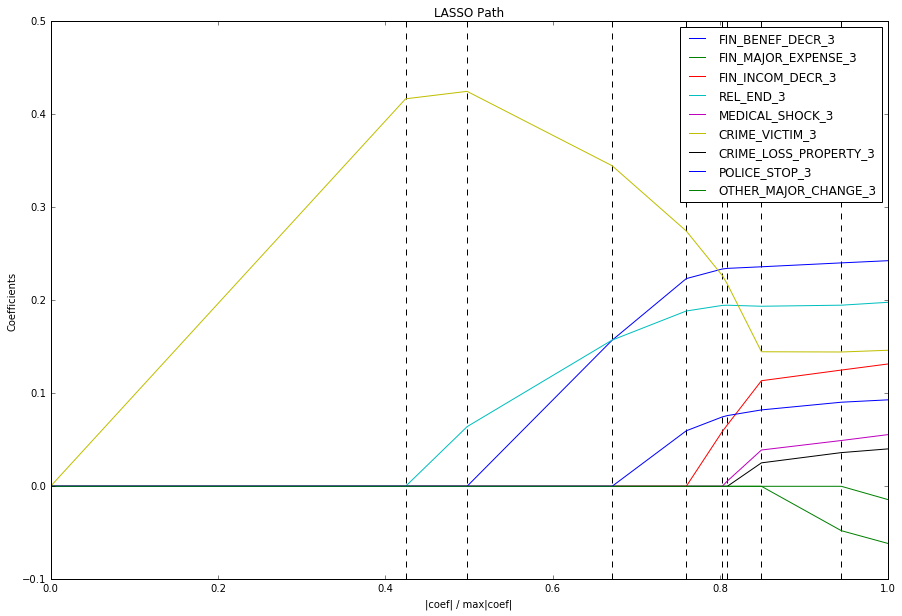

In [115]:
## Lasso LARS Path Test

from sklearn import linear_model
from sklearn import datasets

X, y = fulldata, outcome
X = X[mainfeatures[23:32]]
#X = X[mainfeatures]
y = y[~X.isnull().any(axis=1)]
X = X[~X.isnull().any(axis=1)]
features = X.columns
X = np.array(X)

print("Computing regularization path using the LARS ...")
_, _, coefs = linear_model.lars_path(X, y, method='lasso', verbose=True)

xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

f = plt.figure(figsize=(15, 10))
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.legend(features)
plt.show()

In [156]:
## Filter Feature Selection
from sklearn.feature_selection import VarianceThreshold
X, y = fulldata, outcome
X = X[mainfeatures]
y = y[~X.isnull().any(axis=1)]
X = X[~X.isnull().any(axis=1)]

constant_filter = VarianceThreshold(threshold=0.05)
constant_filter.fit(X)

len(X.columns[constant_filter.get_support()])

constant_columns = [column for column in X.columns
                    if column not in X.columns[constant_filter.get_support()]]


In [130]:
np.sum(X['HOUSE_SHELTER_BASE']!=2)

27

In [153]:
print(constant_columns)
print(X['CRIME_VICTIM_3'].value_counts()) # 2 is no, 1 is yes
print(np.var(X['CRIME_VICTIM_3']))
X.drop(labels=constant_columns, axis=1, inplace=True)

['HOUSE_OTHERS_BASE', 'HOUSE_SHELTER_BASE', 'CRIME_VICTIM_3', 'CRIME_VICTIM_6', 'CRIME_VICTIM_9']
2.0    893
1.0     36
Name: CRIME_VICTIM_3, dtype: int64
0.03724967875222639


In [158]:
print(X['CRIME_VICTIM_9'].value_counts()) # 2 is no, 1 is yes

2.0    900
1.0     29
Name: CRIME_VICTIM_9, dtype: int64


In [ ]:
correlated_features = set()
correlation_matrix = X.corr()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            print(correlation_matrix.columns[i], correlation_matrix.columns[j])
            print(correlation_matrix.iloc[i, j])
            correlated_features.add(colname)
            
correlated_features
            
## SPMTHRESH_BASE OPMTHRESH_BASE are correlated, MEDICAL_SHOCK_6 REL_END_6 are perfectly. We'll keep them.


In [161]:
#Wrapper Feature Selection using Sequential Forward Selection/Step Forward Feature Selection
#from https://stackabuse.com/applying-wrapper-methods-in-python-for-feature-selection/
warnings.filterwarnings('ignore')

from mlxtend.feature_selection import SequentialFeatureSelector

X, y = fulldata, outcome
X = X[mainfeatures[8:]]
y = y[~X.isnull().any(axis=1)]
X = X[~X.isnull().any(axis=1)]

train_features, test_features, train_labels, test_labels = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=41)


feature_selector = SequentialFeatureSelector(RandomForestClassifier(n_jobs=-1),
           k_features=5,
           forward=True,
           verbose=2,
           scoring='f1',
           cv=5)
features = feature_selector.fit(np.array(train_features.fillna(0)), train_labels)
filtered_features= train_features.columns[list(features.k_feature_idx_)]
filtered_features

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  42 out of  42 | elapsed:    1.9s finished

[2019-12-16 21:35:46] Features: 1/5 -- score: 0.4674604155508864[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  41 out of  41 | elapsed:    1.8s finished

[2019-12-16 21:35:48] Features: 2/5 -- score: 0.48550865433959667[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    1.8s finished

[2019-12-16 21:35:49] Features: 3/5 -- score: 0.5164565638411601[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1

Index(['FOODFREE_BASE', 'FOODRUNOUT_BASE', 'HOUSE_SHELTER_BASE',
       'HEALTHDISAB_BASE', 'OTHER_MAJOR_CHANGE_9'],
      dtype='object')

In [ ]:
#Exahustive Feature Selection
from mlxtend.feature_selection import ExhaustiveFeatureSelector
X, y = fulldata, outcome
X = X[mainfeatures]
y = y[~X.isnull().any(axis=1)]
X = X[~X.isnull().any(axis=1)]

train_features, test_features, train_labels, test_labels = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=41)

feature_selector = ExhaustiveFeatureSelector(RandomForestClassifier(n_jobs=-1),
           min_features=3,
           max_features=4,
           scoring='f1',
           print_progress=True,
           cv=5)

features = feature_selector.fit(np.array(train_features.fillna(0)), train_labels)
filtered_features= train_features.columns[list(features.k_feature_idx_)]
filtered_features

In [ ]:
clf = RandomForestClassifier(n_estimators=100, random_state=41, max_depth=3)
clf.fit(train_features[filtered_features], train_labels)

train_pred = clf.predict(train_features[filtered_features])
print('F1 on training set: {}'.format(f1_score(train_labels, train_pred)))

test_pred = clf.predict(test_features[filtered_features].fillna(0))
print('F1 on test set: {}'.format(f1_score(test_labels, test_pred)))

print('Kfold cross-validation:', cross_val_score(RandomForestClassifier(n_estimators=100, max_depth=2), X[filtered_features], y, cv=5, n_jobs=-1))

# forwards result
# F1 on training set: 0.44837758112094395
# F1 on test set: 0.6041666666666667
# Kfold cross-validation: [0.7311828  0.75806452 0.73655914 0.73655914 0.76756757]

# backwards result
# F1 on training set: 0.4066666666666667
# F1 on test set: 0.41975308641975306
# Kfold cross-validation: [0.70967742 0.70430108 0.72043011 0.70430108 0.6972973 ]

### Interpretability

##### One ideal outcome: we've collected a ton of data, if you only need to go back once or twice instead of three times in the future b/c most questions are highly related. Or if we only need to use a small subset of the questions/data. 

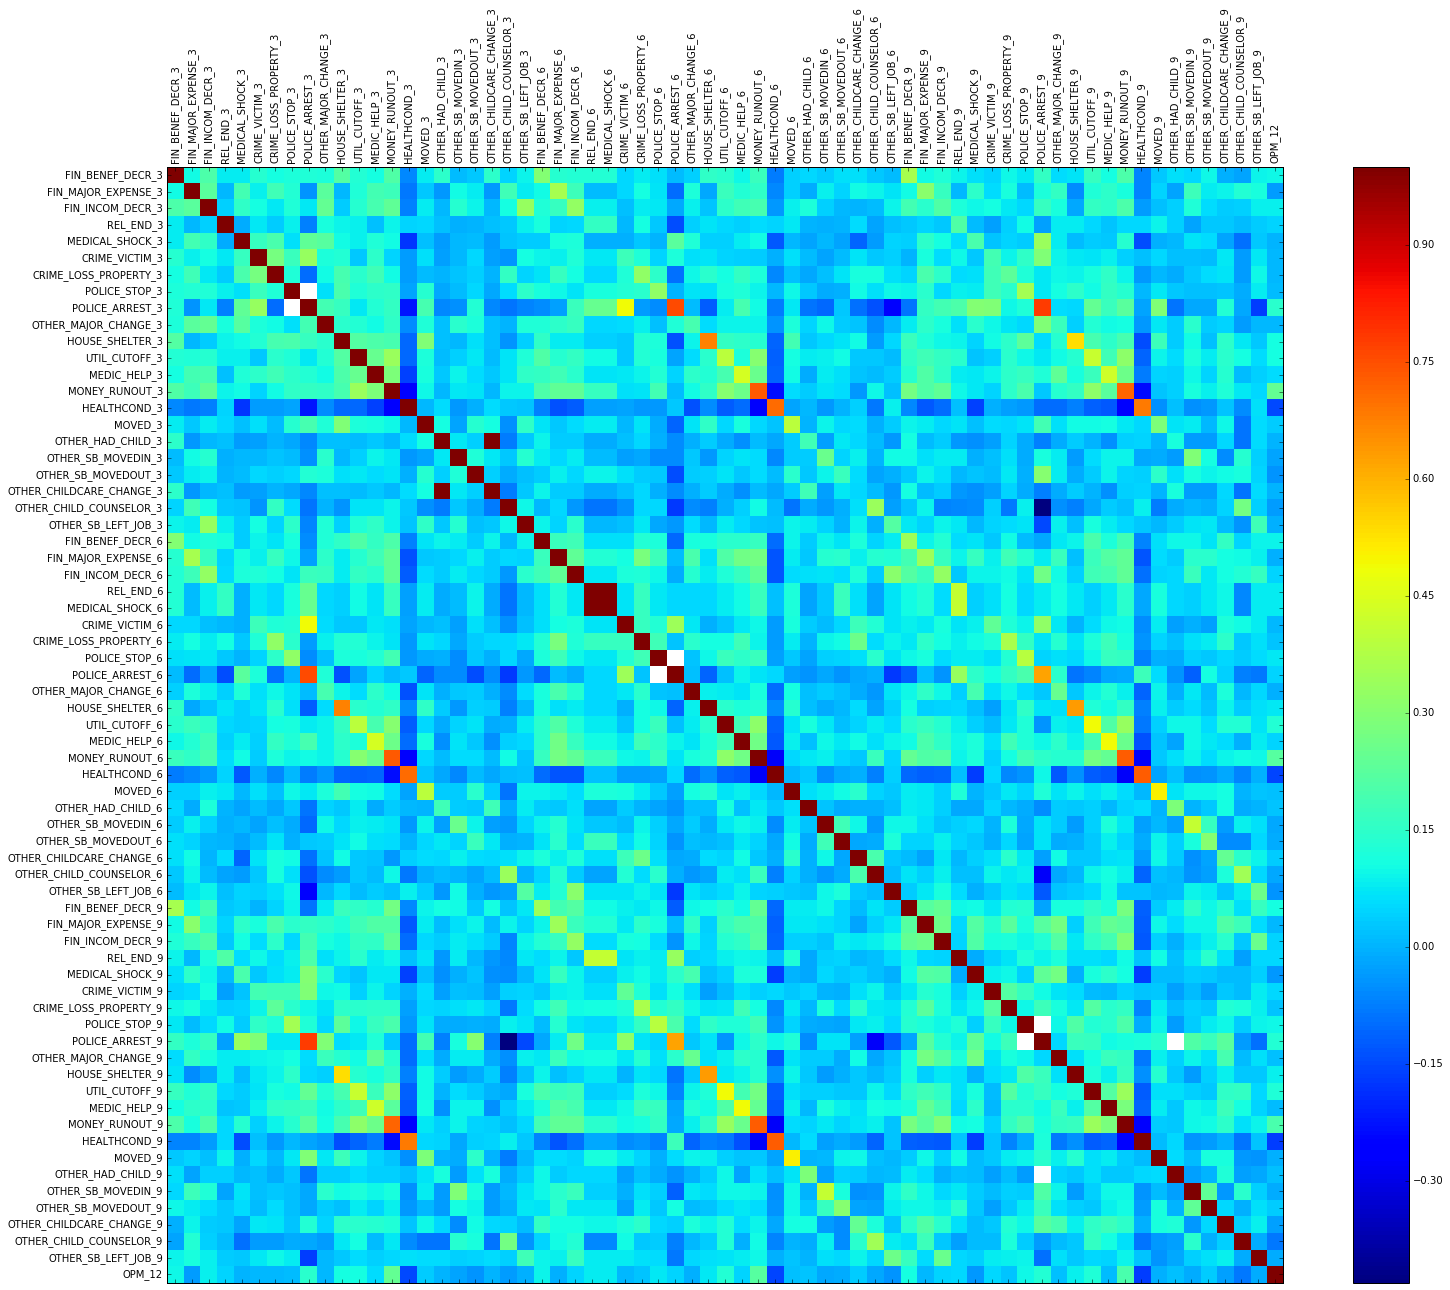

In [49]:
import matplotlib.pyplot as plt
# Correlation to show that the features are not independent, so naive bayes is probably not the best model.
#X = fulldata
X = fulldata.iloc[:,46:]
X['OPM_12'] = outcome

f = plt.figure(figsize=(25, 20))
plt.matshow(X.corr(), fignum=f.number)
plt.xticks(range(X.shape[1]), X.columns, fontsize=10, rotation=90)
plt.yticks(range(X.shape[1]), X.columns, fontsize=10)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=10)
#plt.title('Correlation Matrix', fontsize=16);

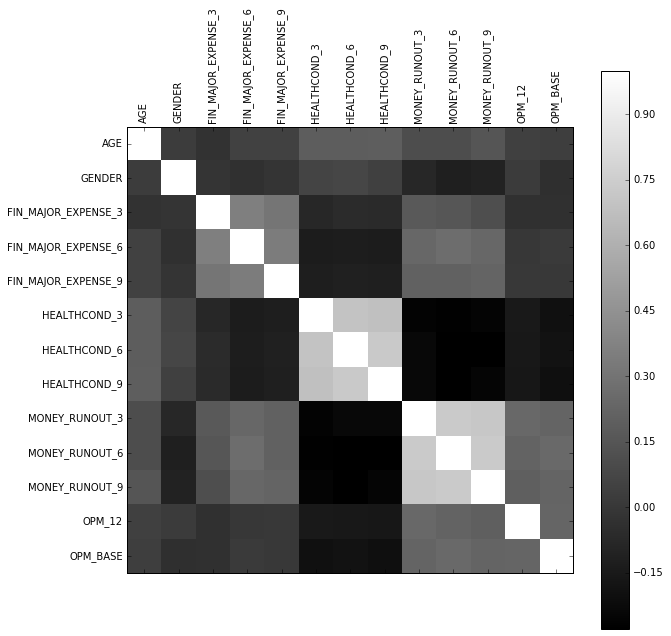

In [205]:
# Correlation with a few of the more interesting features.
X = fulldata
X['OPM_12'] = outcome
X = X[['AGE','GENDER','FIN_MAJOR_EXPENSE_3','FIN_MAJOR_EXPENSE_6','FIN_MAJOR_EXPENSE_9','HEALTHCOND_3','HEALTHCOND_6','HEALTHCOND_9','MONEY_RUNOUT_3','MONEY_RUNOUT_6','MONEY_RUNOUT_9','OPM_12','OPM_BASE']]

f = plt.figure(figsize=(10, 10))
plt.matshow(X.corr(), fignum=f.number,cmap='gray')
plt.xticks(range(X.shape[1]), X.columns, fontsize=10, rotation=90)
plt.yticks(range(X.shape[1]), X.columns, fontsize=10)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=10)
#plt.title('Correlation Matrix', fontsize=16);

In [ ]:
np.corrcoef(X.MONEY_RUNOUT_BASE[~X.MONEY_RUNOUT_BASE.isnull() & ~X.UTIL_PAID_BASE.isnull()],X.UTIL_PAID_BASE[~X.MONEY_RUNOUT_BASE.isnull() & ~X.UTIL_PAID_BASE.isnull()])

In [ ]:
sum(X.MONEY_RUNOUT_BASE.isnull())

In [ ]:
from itertools import combinations

X, y = fulldata, outcome
X = X.drop(["INC_BASE","SINC_BASE","RELINC_BASE","RETIRINC_BASE","DSBINC_BASE","PWELFINC_BASE","UNECOMP_BASE","SNAPINC_BASE","REGASTINC_BASE","ADDINC_BASE","NETINHOME_BASE","NETOUTHOME_BASE","SPOUSE_HEALTHCOND_BASE","POLICE_ARREST_3","POLICE_ARREST_6","POLICE_ARREST_9","OTHER_CHILDCARE_CHANGE_3","OTHER_CHILD_COUNSELOR_3","OTHER_SB_LEFT_JOB_3","OTHER_CHILDCARE_CHANGE_6","OTHER_CHILD_COUNSELOR_6","OTHER_SB_LEFT_JOB_6","OTHER_CHILDCARE_CHANGE_9","OTHER_CHILD_COUNSELOR_9","OTHER_SB_LEFT_JOB_9"], axis = 1)
X = X.iloc[:,33:]
# shocks = ['FIN_BENEF_DECR_', 'FIN_MAJOR_EXPENSE_', 'FIN_INCOM_DECR_',
#        'REL_END_', 'MEDICAL_SHOCK_', 'CRIME_VICTIM_',
#        'CRIME_LOSS_PROPERTY_', 'POLICE_STOP_', 'OTHER_MAJOR_CHANGE_',
#        'HOUSE_SHELTER_', 'UTIL_CUTOFF_', 'MEDIC_HELP_', 'MONEY_RUNOUT_',
#        'HEALTHCOND_', 'MOVED_', 'OTHER_HAD_CHILD_', 'OTHER_SB_MOVEDIN_',
#        'OTHER_SB_MOVEDOUT_']
# shocks = [shock + '9' for shock in shocks]
# X = X[shocks]
y = y[~X.isnull().any(axis=1)]
X = X[~X.isnull().any(axis=1)]

pairs = []
pairfracs = []
for combo in combinations(X.columns, 2):  # 2 for pairs, 3 for triplets, etc
    both = (X[combo[0]] == 1) & (X[combo[1]] == 1)
    either = (X[combo[0]] == 1) | (X[combo[1]] == 1)
    if sum(both)/sum(either) > 0.35:
        print(combo, sum(either))
        pairs += [combo]
        pairfracs += [sum(both)/sum(either)]

In [ ]:
fig, ax = plt.subplots(figsize = (10,6))
y_pos = np.arange(len(pairs))

ax.barh(y_pos, pairfracs)
ax.set_yticks(y_pos+0.5)
ax.set_yticklabels(pairs)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Co-Occurrence Fraction (# where both occur/# where at least one occurs)')
ax.set_title('Pair of Shocks')

plt.show()

In [141]:
from itertools import combinations

X, y = fulldata, outcome
X = X[mainfeatures[23:]]
# X = X.drop(["INC_BASE","SINC_BASE","RELINC_BASE","RETIRINC_BASE","DSBINC_BASE","PWELFINC_BASE","UNECOMP_BASE","SNAPINC_BASE","REGASTINC_BASE","ADDINC_BASE","NETINHOME_BASE","NETOUTHOME_BASE","SPOUSE_HEALTHCOND_BASE","POLICE_ARREST_3","POLICE_ARREST_6","POLICE_ARREST_9","OTHER_CHILDCARE_CHANGE_3","OTHER_CHILD_COUNSELOR_3","OTHER_SB_LEFT_JOB_3","OTHER_CHILDCARE_CHANGE_6","OTHER_CHILD_COUNSELOR_6","OTHER_SB_LEFT_JOB_6","OTHER_CHILDCARE_CHANGE_9","OTHER_CHILD_COUNSELOR_9","OTHER_SB_LEFT_JOB_9"], axis = 1)
# X = X.iloc[:,33:]
# shocks = ['FIN_BENEF_DECR_', 'FIN_MAJOR_EXPENSE_', 'FIN_INCOM_DECR_',
#        'REL_END_', 'MEDICAL_SHOCK_', 'CRIME_VICTIM_',
#        'CRIME_LOSS_PROPERTY_', 'POLICE_STOP_', 'OTHER_MAJOR_CHANGE_',
#        'HOUSE_SHELTER_', 'UTIL_CUTOFF_', 'MEDIC_HELP_', 'MONEY_RUNOUT_',
#        'HEALTHCOND_', 'MOVED_', 'OTHER_HAD_CHILD_', 'OTHER_SB_MOVEDIN_',
#        'OTHER_SB_MOVEDOUT_']
# shocks = [shock + '9' for shock in shocks]
# X = X[shocks]
y = y[~X.isnull().any(axis=1)]
X = X[~X.isnull().any(axis=1)]

trios = []
triofracs = []
for combo in combinations(X.columns, 3):  # 2 for pairs, 3 for triplets, etc
    both = (X[combo[0]] == 1) & (X[combo[1]] == 1) & (X[combo[2]] == 1)
    either = (X[combo[0]] == 1) | (X[combo[1]] == 1) | (X[combo[2]] == 1)
    if sum(either) > 0:
        if sum(both)/sum(either) > 0.12:
            print(combo, sum(either))
            trios += [combo]
            triofracs += [sum(both)/sum(either)]

('FIN_BENEF_DECR_3', 'REL_END_6', 'MEDICAL_SHOCK_6') 128
('FIN_MAJOR_EXPENSE_3', 'FIN_MAJOR_EXPENSE_6', 'FIN_MAJOR_EXPENSE_9') 362
('REL_END_3', 'REL_END_6', 'MEDICAL_SHOCK_6') 117
('FIN_MAJOR_EXPENSE_6', 'REL_END_6', 'MEDICAL_SHOCK_6') 244
('REL_END_6', 'MEDICAL_SHOCK_6', 'CRIME_LOSS_PROPERTY_6') 128
('REL_END_6', 'MEDICAL_SHOCK_6', 'FIN_MAJOR_EXPENSE_9') 226
('REL_END_6', 'MEDICAL_SHOCK_6', 'REL_END_9') 112


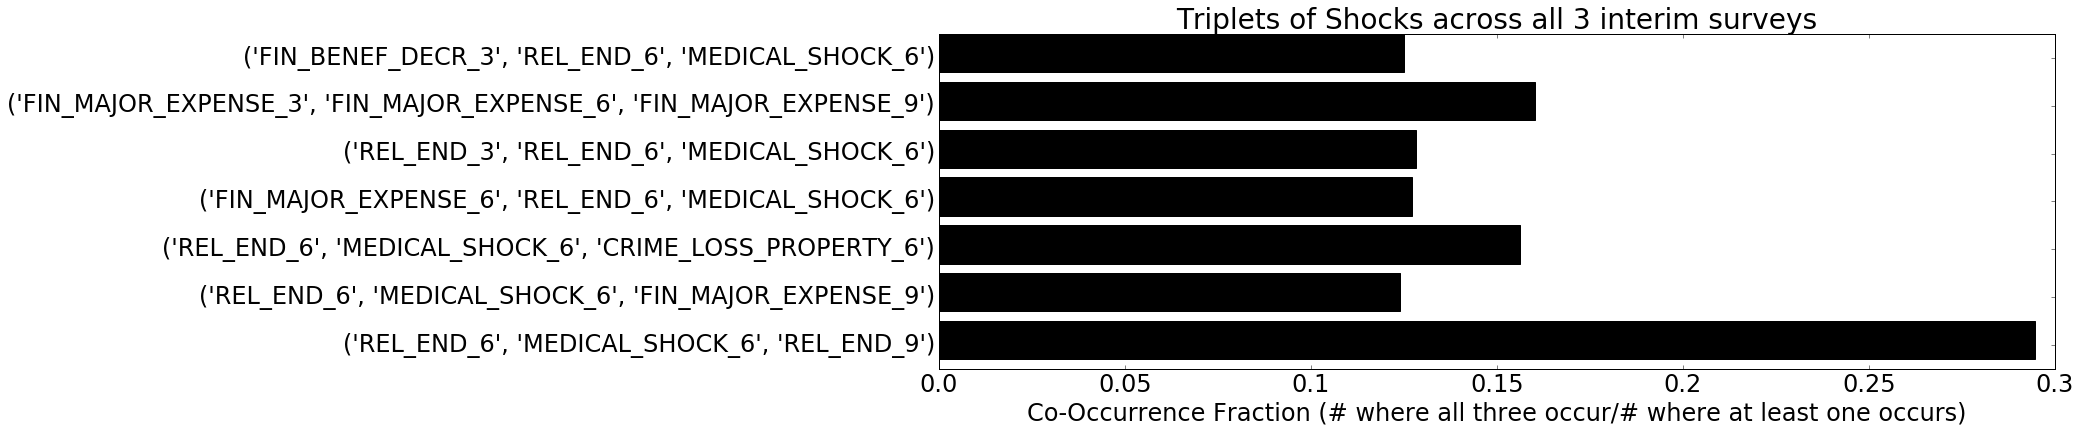

In [142]:
fig, ax = plt.subplots(figsize=(20, 6))
y_pos = np.arange(len(trios))

ax.barh(y_pos, triofracs, color = 'black')
ax.set_yticks(y_pos+0.5)
ax.set_yticklabels(trios, fontsize = 24)
#ax.set_xticklabels([0.0, 0.02, 0.04, 0.06, 0.08, 0.10, 0.12],fontsize = 24)
ax.set_xticklabels([0.0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40],fontsize = 24)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Co-Occurrence Fraction (# where all three occur/# where at least one occurs)', fontsize = 24)
ax.set_title('Triplets of Shocks across all 3 interim surveys',fontsize = 28)

plt.show()

In [ ]:
X, y = fulldata, outcome
X = X.drop(["INC_BASE","SINC_BASE","RELINC_BASE","RETIRINC_BASE","DSBINC_BASE","PWELFINC_BASE","UNECOMP_BASE","SNAPINC_BASE","REGASTINC_BASE","ADDINC_BASE","NETINHOME_BASE","NETOUTHOME_BASE","SPOUSE_HEALTHCOND_BASE","POLICE_ARREST_3","POLICE_ARREST_6","POLICE_ARREST_9","OTHER_CHILDCARE_CHANGE_3","OTHER_CHILD_COUNSELOR_3","OTHER_SB_LEFT_JOB_3","OTHER_CHILDCARE_CHANGE_6","OTHER_CHILD_COUNSELOR_6","OTHER_SB_LEFT_JOB_6","OTHER_CHILDCARE_CHANGE_9","OTHER_CHILD_COUNSELOR_9","OTHER_SB_LEFT_JOB_9"], axis = 1)
X = X.iloc[:,33:]
y = y[~X.isnull().any(axis=1)]
X = X[~X.isnull().any(axis=1)]

decent = [('HOUSE_SHELTER_3', 'HOUSE_SHELTER_6', 'HOUSE_SHELTER_9'),
('MEDIC_HELP_3', 'MEDIC_HELP_6', 'MEDIC_HELP_9'),
('MONEY_RUNOUT_3', 'MONEY_RUNOUT_6', 'MONEY_RUNOUT_9'),
('HEALTHCOND_3', 'HEALTHCOND_6', 'HEALTHCOND_9'),
('REL_END_6', 'MEDICAL_SHOCK_6', 'REL_END_9')]

for combo in decent:
    both = (X[combo[0]] == 1) & (X[combo[1]] == 1) & (X[combo[2]] == 1)
    either = (X[combo[0]] == 1) | (X[combo[1]] == 1) | (X[combo[2]] == 1)
    print(sum(both)/sum(either))
    print()

In [143]:
# Permutation Importance

#import eli5
from eli5.sklearn import PermutationImportance, explain_weights

X, y = fulldata, outcome
X = X.drop(["INC_BASE","SINC_BASE","RELINC_BASE","RETIRINC_BASE","DSBINC_BASE","PWELFINC_BASE","UNECOMP_BASE","SNAPINC_BASE","REGASTINC_BASE","ADDINC_BASE","NETINHOME_BASE","NETOUTHOME_BASE","SPOUSE_HEALTHCOND_BASE","POLICE_ARREST_3","POLICE_ARREST_6","POLICE_ARREST_9","OTHER_CHILDCARE_CHANGE_3","OTHER_CHILD_COUNSELOR_3","OTHER_SB_LEFT_JOB_3","OTHER_CHILDCARE_CHANGE_6","OTHER_CHILD_COUNSELOR_6","OTHER_SB_LEFT_JOB_6","OTHER_CHILDCARE_CHANGE_9","OTHER_CHILD_COUNSELOR_9","OTHER_SB_LEFT_JOB_9"], axis = 1)
#X = X[mainfeatures]
X = X.iloc[:,33:]
y = y[~X.isnull().any(axis=1)]
X = X[~X.isnull().any(axis=1)]
features = X.columns

scaler = StandardScaler().fit(X)
X = scaler.transform(X)

logit = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial',max_iter=200).fit(X,y)

perm = PermutationImportance(logit, random_state=0).fit(X, y)
explain_weights.explain_permutation_importance(perm, feature_names = features.tolist())


Weight,Feature
0.4210 ± 0.0368,OPM_12
0 ± 0.0000,CRIME_LOSS_PROPERTY_6
0 ± 0.0000,CRIME_VICTIM_6
0 ± 0.0000,MEDICAL_SHOCK_6
0 ± 0.0000,REL_END_6
0 ± 0.0000,FIN_INCOM_DECR_6
0 ± 0.0000,FIN_MAJOR_EXPENSE_6
0 ± 0.0000,FIN_BENEF_DECR_6
0 ± 0.0000,OTHER_SB_MOVEDOUT_3
0 ± 0.0000,FIN_INCOM_DECR_3


In [164]:
## TODO: Random Forest Visualization of Trees and F-Scores for interpretability
#copied from https://towardsdatascience.com/how-to-visualize-a-decision-tree-from-a-random-forest-in-python-using-scikit-learn-38ad2d75f21c

# Model
X, y = fulldata, outcome
X = X.drop(["INC_BASE","SINC_BASE","RELINC_BASE","RETIRINC_BASE","DSBINC_BASE","PWELFINC_BASE","UNECOMP_BASE","SNAPINC_BASE","REGASTINC_BASE","ADDINC_BASE","NETINHOME_BASE","NETOUTHOME_BASE","SPOUSE_HEALTHCOND_BASE","POLICE_ARREST_3","POLICE_ARREST_6","POLICE_ARREST_9","OTHER_CHILDCARE_CHANGE_3","OTHER_CHILD_COUNSELOR_3","OTHER_SB_LEFT_JOB_3","OTHER_CHILDCARE_CHANGE_6","OTHER_CHILD_COUNSELOR_6","OTHER_SB_LEFT_JOB_6","OTHER_CHILDCARE_CHANGE_9","OTHER_CHILD_COUNSELOR_9","OTHER_SB_LEFT_JOB_9"], axis = 1)
X = X[mainfeatures[23:]]
# X = X[['AGE','GENDER','OPM_BASE', 'OPMTHRESH_BASE', 'OPMRES_BASE',
#        'SPM_BASE', 'SPMTHRESH_BASE', 'SPMRES_BASE', 'FOODFREE_BASE',
#        'FOODAMOUNT_BASE', 'FOODWORRY_BASE', 'FOODRUNOUT_BASE',
#        'HOUSE_PAID_IN_FULL_BASE', 'HOUSE_OTHERS_BASE', 'HOUSE_SHELTER_BASE',
#        'UTIL_PAID_BASE', 'UTIL_CUTOFF_BASE', 'MONEY_RUNOUT_BASE',
#        'MEDIC_HELP_BASE', 'HEALTHCOND_BASE', 'HEALTHDISAB_BASE',
#        'HEALTHDPRSS_BASE', 'HEALTHANXIOUS_BASE',
#       'FIN_BENEF_DECR_3', 'FIN_MAJOR_EXPENSE_3', 'FIN_INCOM_DECR_3',
#        'REL_END_3', 'MEDICAL_SHOCK_3', 'CRIME_VICTIM_3',
#        'CRIME_LOSS_PROPERTY_3', 'POLICE_STOP_3', 'OTHER_MAJOR_CHANGE_3',
#       'FIN_BENEF_DECR_6', 'FIN_MAJOR_EXPENSE_6',
#        'FIN_INCOM_DECR_6', 'REL_END_6', 'MEDICAL_SHOCK_6', 'CRIME_VICTIM_6',
#        'CRIME_LOSS_PROPERTY_6', 'POLICE_STOP_6', 'OTHER_MAJOR_CHANGE_6',
#       'FIN_BENEF_DECR_9', 'FIN_MAJOR_EXPENSE_9',
#        'FIN_INCOM_DECR_9', 'REL_END_9', 'MEDICAL_SHOCK_9', 'CRIME_VICTIM_9',
#        'CRIME_LOSS_PROPERTY_9', 'POLICE_STOP_9', 'OTHER_MAJOR_CHANGE_9']]

y = y[~X.isnull().any(axis=1)]
X = X[~X.isnull().any(axis=1)]

features = X.columns

x_train,x_test,y_train,y_test=train_test_split(X,y,test_size = 0.2, random_state = 1)

scaler = StandardScaler().fit(X)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
X = scaler.transform(X)

RF = RandomForestClassifier(n_estimators=100, max_depth=2,random_state=1).fit(X, y)

# Train
#model.fit(x_train, y_train)
# Extract single tree
for i in range(1):
    estimator = RF.estimators_[i]

    from sklearn.tree import export_graphviz
    # Export as dot file
    export_graphviz(estimator, out_file='trees/tree%s.dot'%i, 
                    feature_names = features.tolist(),
                    rounded = True, proportion = False, 
                    precision = 2, filled = True)

    # Convert to png using system command (requires Graphviz)
    from subprocess import call
    call(['dot', '-Tpng', 'trees/tree%s.dot'%i, '-o', 'trees/tree%s.png'%i, '-Gdpi=100'])

    # Display in jupyter notebook
    from IPython.display import Image
    Image(filename = 'trees/tree%s.png'%i)

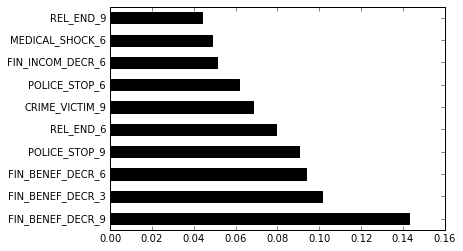

In [166]:
#from sklearn.inspection import permutation_importance

feat_importances = pd.Series(RF.feature_importances_, index=features)
feat_importances.nlargest(10).plot(kind='barh', color='black')
plt.show()

#perm = PermutationImportance(RF, random_state=1).fit(X, y)
# eli5.show_weights(perm, feature_names = X.columns.tolist())

#result = permutation_importance(RF, X, y, n_repeats=10,
#                                random_state=42, n_jobs=2)
#sorted_idx = result.importances_mean.argsort()

# fig, ax = plt.subplots()
# ax.boxplot(result.importances[sorted_idx].T,
#            vert=False, labels=X.columns[sorted_idx])
# ax.set_title("Permutation Importances (train set)")
# fig.tight_layout()
# plt.show()

In [200]:
#condition = (fulldata['GENDER']==2) #Male is 1, Female is 2.
avgimportances = []
conditions = [(fulldata['GENDER']>0), (fulldata['GENDER']==1), (fulldata['GENDER']==2), (fulldata['AGE']<35),(fulldata['AGE']>=35) & (fulldata['AGE']<65), (fulldata['AGE']>=65)]
#condition = (fulldata['AGE']>=65) # (fulldata['AGE']>=35) & (fulldata['AGE']<65)
for condition in conditions:
    X, y = fulldata[condition], outcome[condition]
    X = X[mainfeatures[23:]]
    y = y[~X.isnull().any(axis=1)]
    X = X[~X.isnull().any(axis=1)]

    features = X.columns
    scaler = StandardScaler().fit(X)
    X = scaler.transform(X)

    RF = RandomForestClassifier(n_estimators=100, max_depth=2,random_state=1).fit(X, y)

    feat_importances = pd.Series(RF.feature_importances_, index=features)
    importances = []
    for i in ['FIN_BENEF_DECR_','FIN_MAJOR_EXPENSE_','FIN_INCOM_DECR_','MEDICAL_SHOCK_','REL_END_','CRIME_VICTIM_','CRIME_LOSS_PROPERTY_', 'POLICE_STOP_','OTHER_MAJOR_CHANGE_']:
        importances += [np.mean(feat_importances[[i+'3',i+'6',i+'9']])]
    avgimportances += [importances]
avgimportances = np.array(avgimportances).transpose()
print(np.array2string(np.around(10*avgimportances,3), separator=' & '))

[[1.125 & 0.562 & 0.949 & 0.816 & 0.779 & 0.474] &
 [0.164 & 0.164 & 0.182 & 0.405 & 0.103 & 0.709] &
 [0.269 & 0.317 & 0.408 & 0.564 & 0.324 & 0.263] &
 [0.214 & 0.262 & 0.389 & 0.262 & 0.339 & 0.301] &
 [0.496 & 0.235 & 0.527 & 0.227 & 0.434 & 0.134] &
 [0.296 & 0.324 & 0.251 & 0.206 & 0.348 & 0.311] &
 [0.12  & 0.303 & 0.165 & 0.42  & 0.118 & 0.603] &
 [0.589 & 0.957 & 0.327 & 0.207 & 0.803 & 0.276] &
 [0.06  & 0.209 & 0.136 & 0.226 & 0.086 & 0.262]]


In [180]:
feat_importances

FIN_BENEF_DECR_3         0.101045
FIN_MAJOR_EXPENSE_3      0.015972
FIN_INCOM_DECR_3         0.012723
REL_END_3                0.026056
MEDICAL_SHOCK_3          0.003084
CRIME_VICTIM_3           0.013663
CRIME_LOSS_PROPERTY_3    0.009257
POLICE_STOP_3            0.024839
OTHER_MAJOR_CHANGE_3     0.005897
FIN_BENEF_DECR_6         0.093597
FIN_MAJOR_EXPENSE_6      0.011483
FIN_INCOM_DECR_6         0.050932
REL_END_6                0.079065
MEDICAL_SHOCK_6          0.048480
CRIME_VICTIM_6           0.006902
CRIME_LOSS_PROPERTY_6    0.018207
POLICE_STOP_6            0.061494
OTHER_MAJOR_CHANGE_6     0.001535
FIN_BENEF_DECR_9         0.142728
FIN_MAJOR_EXPENSE_9      0.021686
FIN_INCOM_DECR_9         0.017090
REL_END_9                0.043798
MEDICAL_SHOCK_9          0.012593
CRIME_VICTIM_9           0.068102
CRIME_LOSS_PROPERTY_9    0.008612
POLICE_STOP_9            0.090458
OTHER_MAJOR_CHANGE_9     0.010703
dtype: float64

In [ ]:
model

In [ ]:
from sklearn.ensemble.partial_dependence import plot_partial_dependence

plot_partial_dependence(RF, X, ['AGE',('Age', 'INC_IMP_BASE')]) 

In [ ]:
from sklearn.datasets import make_friedman1
from sklearn.inspection import plot_partial_dependence

from sklearn.ensemble import GradientBoostingRegressor
X, y = make_friedman1()
clf = GradientBoostingRegressor(n_estimators=10).fit(X, y)
plot_partial_dependence(clf, X, [0, (0, 1)]) 

In [ ]:
import sklearn.ensemble